# Alard-Lupton simple implementation

No variable PSF or background estimation.

The method just constructs the LLS matrix, and inverts it directly.  
It is straight forward, except for the las step where we align the transformed image to match the science image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.modeling import models
from astropy.convolution import convolve_fft, convolve

In [3]:
from astropy.visualization import ZScaleInterval

Just for visualization

In [4]:
zscale = ZScaleInterval()

We start with zeros and randomly place non-zero pixels with uniform intensities from 0.5 to 1.

In [5]:
im_N = np.zeros((512, 512))
im_R = np.zeros((512, 512))

In [6]:
x, y = np.random.randint(510, size=100), np.random.randint(510, size=100)

In [7]:
for xx, yy in zip(x, y):
    random_brightness = np.random.random()*0.5 + 0.5
    im_N[xx, yy] = random_brightness
    im_R[xx, yy] = random_brightness

# adding a transient
im_N[125, 387] = 0.16

We generate two different PSF for the reference and the new image

In [8]:
psf_N = models.Gaussian2D(amplitude=1, x_mean=25, y_mean=25, x_stddev=4, y_stddev=3.5)
psf_R = models.Gaussian2D(amplitude=1, x_mean=25, y_mean=25, x_stddev=1.5, y_stddev=1.5)

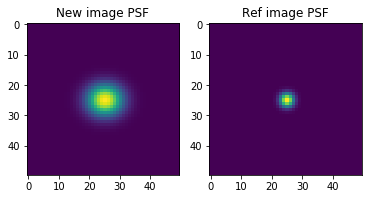

In [9]:
plt.subplot(121)
plt.title('New image PSF')
plt.imshow(psf_N.render(np.zeros((50, 50))))
plt.subplot(122)
plt.title('Ref image PSF')
plt.imshow(psf_R.render(np.zeros((50,50))))
#plt.colorbar()

We convolve this PSF with the original frames, and add some gaussian random noise.  
Notice that the variance of the random noise is different in each frame, and the reference has 10 times less standard deviation, which means a factor of 100 in variance.

In [10]:
imgN = convolve(im_N, psf_N.render())*10e4 + np.random.normal(size=(512, 512), loc=500, scale=50)
imgR = convolve(im_R, psf_R.render())*10e4 + np.random.normal(size=(512, 512), loc=500, scale=5)

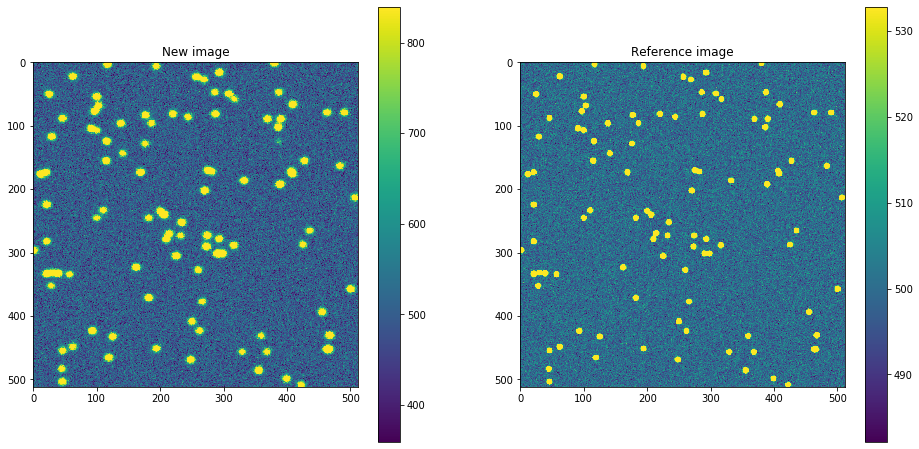

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('New image')
vmin, vmax = zscale.get_limits(imgN)
plt.imshow(imgN, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(122)
plt.title('Reference image')
vmin, vmax = zscale.get_limits(imgR)
plt.imshow(imgR, vmin=vmin, vmax=vmax)
plt.colorbar()


We can estimate some simple robust statistics using clipping 

In [12]:
from astropy.stats import sigma_clipped_stats

In [13]:
print('mean = {}, median = {}, std = {}'.format(*sigma_clipped_stats(imgN)))
print('mean = {}, median = {}, std = {}'.format(*sigma_clipped_stats(imgR)))

mean = 504.6500721058657, median = 503.6102530593438, std = 52.10862200412734
mean = 500.0858080714586, median = 500.0659881424086, std = 4.967755192223622


We propose our set of candidate basis for the kernel expansion

In [177]:
bbox = np.zeros_like((65, 65))
basisg = [models.Gaussian2D(amplitude=1, x_mean=33, y_mean=33, x_stddev=1.5, y_stddev=1.5).render(np.zeros((65, 65))), 
          #models.Gaussian2D(amplitude=1, x_mean=33, y_mean=33, x_stddev=2., y_stddev=2.5).render(np.zeros((65, 65))), 
          #models.Gaussian2D(amplitude=1, x_mean=33, y_mean=33, x_stddev=2.5, y_stddev=2.).render(np.zeros((65, 65))), 
          models.Gaussian2D(amplitude=1, x_mean=33, y_mean=33, x_stddev=2.5, y_stddev=2.5).render(np.zeros((65, 65))),
          models.Gaussian2D(amplitude=1, x_mean=33, y_mean=33, x_stddev=3.5, y_stddev=3.5).render(np.zeros((65, 65)))
         ] 


In [178]:
y, x = np.mgrid[:512, :512]

In [197]:
basisp = [x**0, #y**0, 
          x, y, 
          x*y, x*x, y*y, 
          #x*x*y, x*y*y, y**3, x**3, 
          #y**4, x**4, x*y**3, x**2*y**2, x**3*y,
          #y**5, x**5, x*y**4, x**2*y**3, x**3*y**2, x**4*y, 
          #y**6, x**6, x*y**5, x**2*y**4, x**3*y**3, x**4*y**2, y*x**5
         ]

A simple look at them, they are gaussians with different shapes

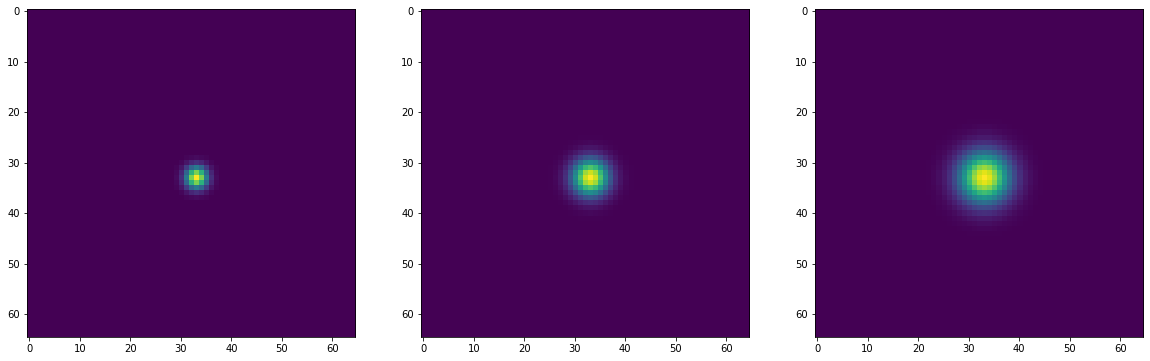

In [198]:
plt.figure(figsize=(20, 8))
for i, abasis in enumerate(basisg):
    plt.subplot(1, len(basisg), i+1)
    plt.imshow(abasis)

Here we actually apply the methodology to build the M matrix

In [199]:
Ci = []
for basis_i in basisg:
    conv = convolve(imgR, basis_i)
    for apol in basisp:
        Ci.append(conv*apol)

In [200]:
sigma = sigma_clipped_stats(imgN)[-1]
v_i = [np.sum(np.sum(imgN*ci/sigma**2)) for ci in Ci]

In [201]:
M = np.zeros(shape=(len(basisg)*len(basisp), len(basisg)*len(basisp)))

for i in range(len(basisg)*len(basisp)):
    for j in range(i+1): #len(basisg)*len(basisp)):
        M[i, j] = np.sum(np.sum(Ci[i]*Ci[j]/sigma**2))
        M[j, i] = M[i, j]

Take a look on M

In [202]:
print(M.round(4))

[[3.05307900e+07 7.71512512e+09 7.68078430e+09 1.95081316e+12
  2.60326882e+12 2.59468886e+12 2.92955871e+07 7.41579419e+09
  7.39102056e+09 1.87896243e+12 2.50402854e+12 2.49836497e+12
  2.83961005e+07 7.19597711e+09 7.17873652e+09 1.82580826e+12
  2.43027298e+12 2.42704042e+12]
 [7.71512512e+09 2.60326882e+12 1.95081316e+12 6.62100868e+14
  9.90116045e+14 6.61667995e+14 7.41579419e+09 2.50402854e+12
  1.87896243e+12 6.37598305e+14 9.52815532e+14 6.37277675e+14
  7.19597711e+09 2.43027298e+12 1.82580826e+12 6.19241654e+14
  9.24787989e+14 6.19058878e+14]
 [7.68078430e+09 1.95081316e+12 2.59468886e+12 6.61667995e+14
  6.62100868e+14 9.90679498e+14 7.39102056e+09 1.87896243e+12
  2.49836497e+12 6.37277675e+14 6.37598305e+14 9.53858136e+14
  7.17873652e+09 1.82580826e+12 2.42704042e+12 6.19058878e+14
  6.19241654e+14 9.26328858e+14]
 [1.95081316e+12 6.62100868e+14 6.61667995e+14 2.25441480e+17
  2.53079974e+17 2.53427928e+17 1.87896243e+12 6.37598305e+14
  6.37277675e+14 2.16962854e+17 2

In [203]:
a = np.dot(np.linalg.inv(M), np.array(v_i))

In [204]:
a.round(3)

array([-0.027,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.204, -0.002,
       -0.001, -0.   ,  0.   ,  0.   ,  0.867,  0.001,  0.001,  0.   ,
       -0.   , -0.   ])

Let's check the final transformation kernel

Calculate the transformation for R and align the images for subtraction

In [205]:
%timeit
trsf = np.zeros_like(imgR)
i = 0
for abasis in basisg:
    conv = convolve(imgR, abasis)
    for a_pol in basisp:
        trsf += conv*a[i]*a_pol
        i += 1
        

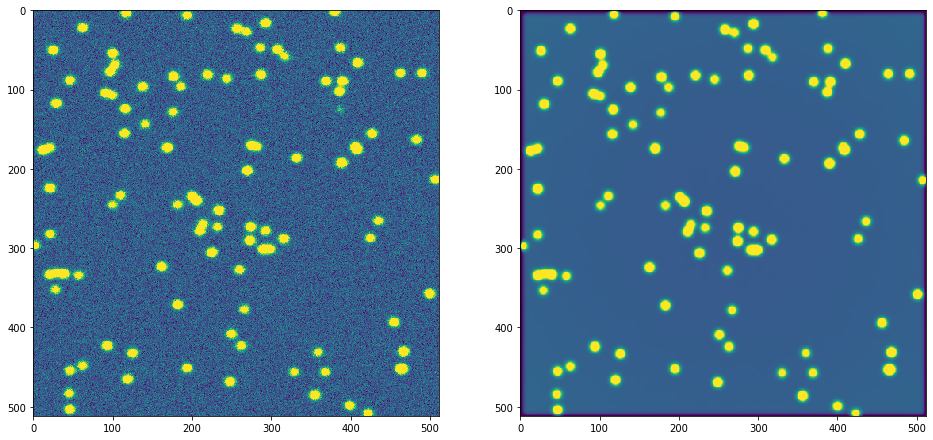

In [206]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
vmin, vmax = zscale.get_limits(imgN)
plt.imshow(imgN, vmin=vmin, vmax=vmax)

plt.subplot(122)
#vmin, vmax = zscale.get_limits(trsf)
plt.imshow(trsf, vmin=vmin, vmax=vmax)


In [207]:
import astroalign as aa

In [208]:
aatrf = aa.register(trsf, imgN)[0]

In [209]:
D = imgN - aatrf

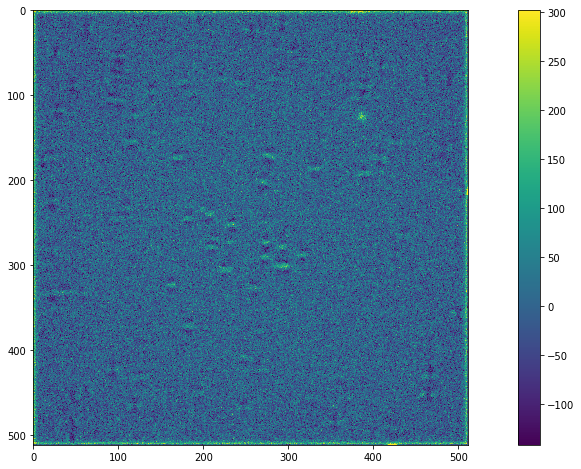

In [210]:
plt.figure(figsize=(18, 8))
vmin, vmax = zscale.get_limits(D)
plt.imshow(D, vmin=vmin, vmax=vmax)
plt.colorbar()

Let's check the residuals, are they normally distributed??

In [211]:
from scipy.stats import norm

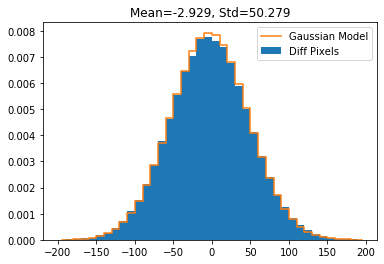

In [212]:
# excluding the border...
bins = np.arange(-200, 200, 10)
plt.hist(D[10:-10, 10:-10].flatten(), density=True, log=False, bins=bins, label='Diff Pixels')
mea, med, sd = sigma_clipped_stats(D[10:-10, 10:-10])
plt.step(bins+5, norm(med, sd).pdf(bins+5), where='mid', label='Gaussian Model')
plt.legend(loc='best')
plt.title('Mean={0:.3f}, Std={1:.3f}'.format(mea, sd))
plt.show()